# WALLABY Catalogue Management

In this notebook we go through a WALLABY administrator workflow to demonstrate how these notebooks can be used for managing the content of the catalogue. This notebook will have write access to the WALLABY database, but will require an authorised user.

We will go through three possible use-cases: the development of duplicate detection algorithms that can be included in `SoFiAX` or to be included as part of future WALLABY workflows in RADEC, performing manual inspection of detections and development of a heuristic for selection of detections for a final source catalogue.


### A. Development of SoFiAX duplicate algorithms

These notebooks can provide a useful workspace to iterate and develop new algorithms for identifying duplicate detections. These can then be added to SoFiAX (or to a source finding pipeline) when complete. The duplicates identified by this new algorithm can then be investigated manually without writing to the database, and can be managed completely in this notebook.

We will do the following to demonstrate this:

1. Develop a simple algorithm for identifying duplicates
2. Verify the algorithm creates the tags we expect.
3. Retrieve objects based on tags.

### B. Manual inspection for components

Manual inspection and management of components can be done as a final step (after automated processes that are implemented in SoFiAX) in this notebook. A WALLABY administrator who identifies two or more detections that are actually a single source can tag, merge and re-run SoFiA and SoFiAX (assuming the cube size is small) in this notebook.

1. Perform some visual inspection and tag detections
2. Re-run SoFiA after identifying components of the same galaxy
3. Re-run SoFiAX to generate outputs for this new source
4. Delete components

### C. Development of heuristics for the final source catalogue

This section has been developed with the understanding that all detection will keep their original names (at the time of identification by `sofia`), and that a final source catalogue will be determined manually after. In this section we demonstrate how the selection heuristics for the final source catalogue can be tested and developed in Python.

# Import libraries + setup Django

Starting point of every notebook that accesses Django models. Run the three cells below to import libraries/modules and setup Django.

In [1]:
# Import libraries

import os
import sys
import json
import django
from datetime import datetime
import numpy as np

In [2]:
# Connect to Django shell

sys.path.append('SoFiAX_services/api/')
django.setup()

In [3]:
# Import Django models

from tables.models import Run, Instance, Detection, Products,\
                          Sources, Comments, Tag, TagDetection

# A. Develop SoFiAX duplicate detection algorithm

We're going to go through the process of developing a very simple duplicate identification algorithm for detections in the database. This naive approach will just look at the position, flux (sum) and position angle similarity between any pair of detections. This algorithm is applied to all pairs of detections in our database, and if the differences are below some threshold for each property, we will visually inspect them and tag if appropriate.

Let's implement this naive duplicate identification algorithm and then apply it on all pairs of detections.

In [4]:
# Write a function that we can test on pairs

def identify_duplicate(d1, d2):
    """Simple and naive duplicate detection algorithm. Can
    update threshold values as necessary.
    
    """
    # Threshold values
    pos_threshold = 10
    flux_threshold = 5
    kin_pa_threshold = 5
    
    # Compute differences between detections
    pos_diff = np.linalg.norm(
        np.array([d1.x, d1.y, d1.z]) - np.array([d2.x, d2.y, d2.z])
    )
    flux_diff = np.abs(d1.f_sum - d2.f_sum)
    kin_pa_diff = np.abs(d1.kin_pa - d2.kin_pa)
    
    # Duplicate logic
    if (pos_diff <= pos_threshold) & (flux_diff <= flux_threshold) & (kin_pa_diff <= kin_pa_threshold):
        return True
    return False

In [5]:
# Apply function on each pair of detections. Let's also filter
# out the detections that have the same name.

detections = Detection.objects.all()
N_detections = len(detections)

detection_pair_ids = []

for i in range(N_detections):
    for j in range(i + 1, N_detections):
        d1 = detections[i]
        d2 = detections[j]
        if identify_duplicate(d1, d2):
            pair = (d1.id, d2.id)
            detection_pair_ids.append(pair)
            print(pair)

(4664, 4027)
(4291, 3507)
(4676, 4035)
(4031, 4669)
(3500, 4382)
(3486, 4331)
(4726, 3914)
(3494, 4334)
(4729, 3918)
(4204, 3549)
(4025, 4662)
(4300, 3509)
(4002, 4724)
(3575, 4174)
(4357, 3496)
(4442, 3623)
(4359, 3681)
(3493, 4355)
(4422, 3487)
(4706, 4005)
(3660, 4346)
(4415, 3642)
(4057, 4628)
(3678, 4423)
(4624, 4055)
(4524, 3780)
(4370, 3679)
(3964, 3685)
(4076, 4649)
(3979, 4307)
(3603, 4261)
(4657, 4085)
(4578, 3941)
(4103, 4698)
(4086, 4658)
(4693, 4100)
(4102, 4697)
(3298, 3307)


We have returned the `id`s for the detections that meet the duplicate identification function criteria and do not have the same name. We could automatically tag these (in the body of the function or as we apply them to pairs of detections). But we could also just inspect them now in the notebook.

**NOTE**: the filter for name should be included in the original function.

## Visualisation 

Tobias has provided a new plotting script that we will use to compare these pairs of sources. Users should feel free to change the content of the cells below and install other libraries they would like to use for their own visualisation.

In [6]:
!pip install astroquery

In [7]:
# libraries

import io
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import PercentileInterval
from astroquery.skyview import SkyView
from astropy.utils.data import clear_download_cache

In [8]:
Products._meta.fields

(<django.db.models.fields.BigAutoField: id>,
 <django.db.models.fields.related.ForeignKey: detection>,
 <django.db.models.fields.BinaryField: cube>,
 <django.db.models.fields.BinaryField: mask>,
 <django.db.models.fields.BinaryField: moment0>,
 <django.db.models.fields.BinaryField: moment1>,
 <django.db.models.fields.BinaryField: moment2>,
 <django.db.models.fields.BinaryField: channels>,
 <django.db.models.fields.BinaryField: spectrum>)

In [9]:
# Define functions for generating plots for inspecting detections

def retrieve_dss_image(longitude, latitude, width, height):
    hdulist = SkyView.get_images(position="{}, {}".format(longitude, latitude), survey=["DSS"], coordinates="J2000", projection="Tan", pixels="{}, {}".format(str(int(2400 * width)), str(int(2400 * height))), width=width*u.deg, height=height*u.deg);
    return hdulist[0][0]

def inspect_plot(detection):
    # Plot figure size    
    interval = PercentileInterval(95.0)
    plt.rcParams["figure.figsize"] = (12,12)
    
    # Retrieve products from database
    products = Products.objects.get(detection=detection)
    
    # Open moment 0 image
    with io.BytesIO() as buf:
        buf.write(products.moment0)
        buf.seek(0)
        hdu_mom0 = fits.open(buf)[0]
        wcs = WCS(hdu_mom0.header)
        mom0 = hdu_mom0.data

    # Open moment 1 image
    with io.BytesIO() as buf:
        buf.write(products.moment1)
        buf.seek(0)
        hdu_mom1 = fits.open(buf)[0]
        mom1 = hdu_mom1.data

    with io.BytesIO() as buf:
        buf.write(b''.join(products.spectrum))
        buf.seek(0)
        spectrum = np.loadtxt(buf, dtype="float", comments="#", unpack=True)

    # Extract coordinate information
    nx = hdu_mom0.header["NAXIS1"]
    ny = hdu_mom0.header["NAXIS2"]
    clon, clat = wcs.all_pix2world(nx/2, ny/2, 0)
    tmp1, tmp3 = wcs.all_pix2world(0, ny/2, 0)
    tmp2, tmp4 = wcs.all_pix2world(nx, ny/2, 0)
    width = np.rad2deg(math.acos(math.sin(np.deg2rad(tmp3)) * math.sin(np.deg2rad(tmp4)) + math.cos(np.deg2rad(tmp3)) * math.cos(np.deg2rad(tmp4)) * math.cos(np.deg2rad(tmp1 - tmp2))))
    tmp1, tmp3 = wcs.all_pix2world(nx/2, 0, 0)
    tmp2, tmp4 = wcs.all_pix2world(nx/2, ny, 0)
    height = np.rad2deg(math.acos(math.sin(np.deg2rad(tmp3)) * math.sin(np.deg2rad(tmp4)) + math.cos(np.deg2rad(tmp3)) * math.cos(np.deg2rad(tmp4)) * math.cos(np.deg2rad(tmp1 - tmp2))))
    
    # Download DSS image from SkyView
    hdu_opt = retrieve_dss_image(clon, clat, width, height)
    wcs_opt = WCS(hdu_opt.header)
    
    # Plot moment 0
    ax2 = plt.subplot(2, 2, 1, projection=wcs);
    ax2.imshow(mom0, origin="lower");
    ax2.grid(color="grey", ls="solid");
    ax2.set_xlabel("Right ascension (J2000)");
    ax2.set_ylabel("Declination (J2000)");
    ax2.tick_params(axis="x", which="both", left=False, right=False);
    ax2.tick_params(axis="y", which="both", top=False, bottom=False);
    ax2.set_title("moment 0");

    # Plot DSS image with HI contours
    bmin, bmax = interval.get_limits(hdu_opt.data);
    ax = plt.subplot(2, 2, 2, projection=wcs_opt);
    ax.imshow(hdu_opt.data, origin="lower");
    ax.contour(hdu_mom0.data, transform=ax.get_transform(wcs), levels=np.logspace(2.0, 5.0, 10), colors="lightgrey", alpha=1.0);
    ax.grid(color="grey", ls="solid");
    ax.set_xlabel("Right ascension (J2000)");
    ax.set_ylabel("Declination (J2000)");
    ax.tick_params(axis="x", which="both", left=False, right=False);
    ax.tick_params(axis="y", which="both", top=False, bottom=False);
    ax.set_title("DSS + moment 0");

    # Plot moment 1
    bmin, bmax = interval.get_limits(mom1);
    ax3 = plt.subplot(2, 2, 3, projection=wcs);
    ax3.imshow(hdu_mom1.data, origin="lower", vmin=bmin, vmax=bmax, cmap=plt.get_cmap("gist_rainbow"));
    ax3.grid(color="grey", ls="solid");
    ax3.set_xlabel("Right ascension (J2000)");
    ax3.set_ylabel("Declination (J2000)");
    ax3.tick_params(axis="x", which="both", left=False, right=False);
    ax3.tick_params(axis="y", which="both", top=False, bottom=False);
    ax3.set_title("moment 1");

    # Plot spectrum
    xaxis = spectrum[1] / 1e+6;
    data  = 1000.0 * np.nan_to_num(spectrum[2]);
    xmin = np.nanmin(xaxis);
    xmax = np.nanmax(xaxis);
    ymin = np.nanmin(data);
    ymax = np.nanmax(data);
    ymin -= 0.1 * (ymax - ymin);
    ymax += 0.1 * (ymax - ymin);
    ax4 = plt.subplot(2, 2, 4);
    ax4.step(xaxis, data, where="mid", color="royalblue");
    ax4.set_xlabel("Frequency (MHz)");
    ax4.set_ylabel("Flux density (mJy)");
    ax4.set_title("spectrum");
    ax4.grid(True);
    ax4.set_xlim([xmin, xmax]);
    ax4.set_ylim([ymin, ymax]);

    plt.suptitle(detection.name.replace("_", " ").replace("-", "−"), fontsize=16);
    plt.show();

    # Clean up
    clear_download_cache(pkgname="astroquery");
    clear_download_cache();

Now that we have the ability to generate plots for comparing, let's do a comparison of a detection with a known mock detection.

indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]


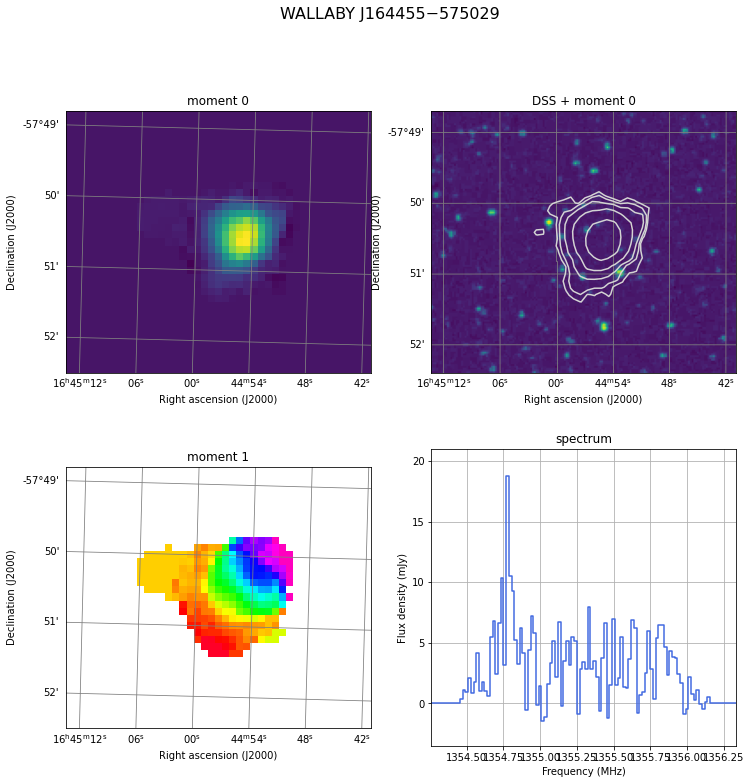

indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]


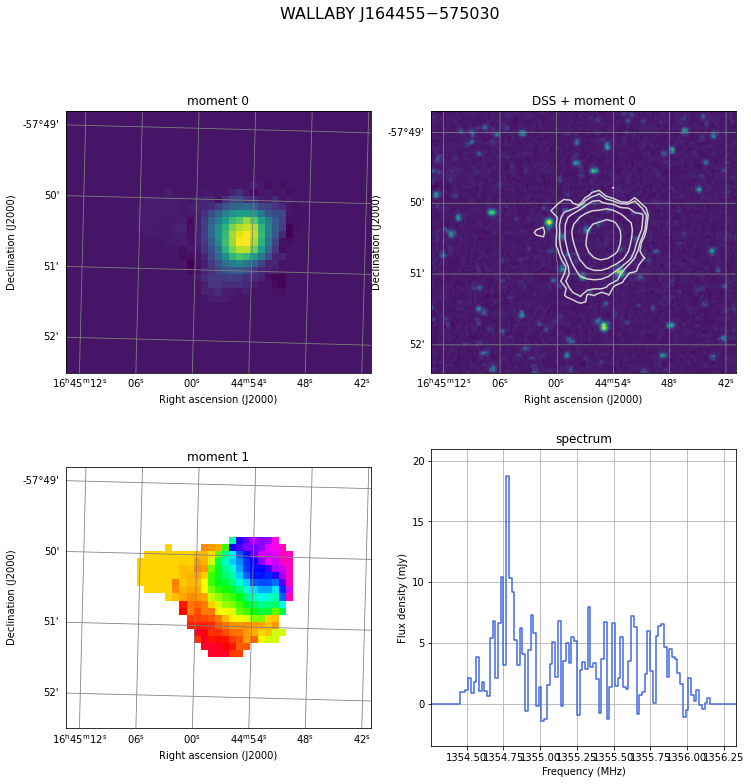

In [29]:
# Inspect plots for detection objects.

%matplotlib inline

detection1 = Detection.objects.get(id=3603)
detection2 = Detection.objects.get(id=4261)

inspect_plot(detection1)
inspect_plot(detection2)

These are duplicates and we know that because they have the same name in the database. Let's leave a tag on one of the detections so that we can refer back to it later (once we figure out what to do with it).

In [11]:
# Create a new tag for this duplicate

tag_name = "Manual inspect duplicate J164455-575029"
if Tag.objects.filter(tag_name=tag_name).exists():
    tag = tag = Tag.objects.get(tag_name=tag_name)
else:
    tag = Tag.objects.get(tag_name=tag_name, added_at=datetime.now())

In [12]:
# Assign tag to these detections

TagDetection.objects.create(tag=tag, detection=detection1)
TagDetection.objects.create(tag=tag, detection=detection2)

<TagDetection: TagDetection object (42)>

In [13]:
tagged_detections = [d.detection for d in TagDetection.objects.all()]
print(tagged_detections)

[<Detection: WALLABY J102800-281838>, <Detection: WALLABY J102800-281838>, <Detection: WALLABY J102800-281838>, <Detection: WALLABY J102800-281838>, <Detection: WALLABY J164455-575029>, <Detection: WALLABY J164455-575030>, <Detection: WALLABY J164455-575029>, <Detection: WALLABY J164455-575030>, <Detection: WALLABY J164455-575029>, <Detection: WALLABY J164455-575030>, <Detection: WALLABY J164455-575029>, <Detection: WALLABY J164455-575030>, <Detection: WALLABY J164455-575029>, <Detection: WALLABY J164455-575030>, <Detection: WALLABY J164455-575029>, <Detection: WALLABY J164455-575030>, <Detection: WALLABY J164455-575029>, <Detection: WALLABY J164455-575030>, <Detection: WALLABY J164455-575029>, <Detection: WALLABY J164455-575030>, <Detection: WALLABY J164455-575029>, <Detection: WALLABY J164455-575030>, <Detection: WALLABY J164455-575029>, <Detection: WALLABY J164455-575030>, <Detection: WALLABY J164455-575029>, <Detection: WALLABY J164455-575030>, <Detection: WALLABY J164455-575029>, 

Great! We see the tags that we have added for this pair of detections. If you see more it's becuase we've run the same cell multiple times (no harm done we can delete `TagDetection` objects easily. We have developed an algorithm that can identify and tag detections in the database. This can be included as part of SoFiAX or as part of a WALLABY source finding workflow in RADEC.

# B. Manual inspection for components

Suppose in the manual exploration of our detections we find that both detections are actually components of the same source. For the purposes of this tutorial, we'll just use the detections identified in the section above even though they don't appear to be components (`id=3603` and `id=4261`). In this case we would want to resolve this issue by re-running `sofia` on the joined cube.

It is possible to run `/bin/bash` commands in the notebook by starting the command in a code cell with `!`. Or, you can use `os.system()` and pass the `bash` command as the argument. Let's check that `sofia` and `sofiax` are both installed by running them without arguments in the cells below.

In [14]:
!sofia

____________________________________________________________________________

 Pipeline started
____________________________________________________________________________

  Using:    Source Finding Application (SoFiA)
  Version:  2.3.1 (22-Apr-2021)
  CPU:      2 cores available
  Time:     Fri May  7 03:08:39 2021


ERROR: Unexpected number of command line arguments.
Usage: sofia <parameter_file>
       Terminating with error code 7.



In [15]:
!sofiax

usage: sofiax [-h] -c CONF -p PARAM [PARAM ...]
sofiax: error: the following arguments are required: -c/--conf, -p/--param


Neat so they are both installed. The steps for making use of this are:

1. Save merged data cubes and masks as files locally
2. Upload `sofia` parameter file(s)
3. Run `sofia`

### 1. Save merged cube and mask locally.

Retrieve the cubes and masks from the database and merge them into new cube and mask files. We will run `sofia` on these products. Script for merging detections taken from Tobias.

In [16]:
# Store cubes as files
# We'll write a function for this and do it for the two detections we are interested in.
# Note that we rely on libraries installed further up

def merge_products(*argc):
    """Merge the cube and mask products for all provided detection objects.
    Developed following `wallmerge.py` provided by Tobias.
    
    """
    detections = list(argc)
    hdu_cubes = []
    hdu_masks = []
    cube_bufs = []
    mask_bufs = []
    
    # read from Products database
    for d in detections:
        products = Products.objects.get(detection=d)
        
        # read cubes
        cube_buf = io.BytesIO()
        cube_buf.write(products.cube)
        cube_buf.seek(0)
        cube_bufs.append(cube_buf)
        cube = fits.open(cube_buf)
        hdu_cubes.append(cube)
        
        # read masks
        mask_buf = io.BytesIO()
        mask_buf.write(products.mask)
        mask_buf.seek(0)
        mask_bufs.append(mask_buf)
        mask = fits.open(mask_buf)
        hdu_masks.append(mask)
            
    hdu0_cubes = [hdu[0] for hdu in hdu_cubes]
    hdu0_masks = [hdu[0] for hdu in hdu_masks]
    
    # Extract dimensions from all cubes
    axes = int(hdu0_cubes[0].header["NAXIS"]);
    naxis = [[int(hdu0_cubes[cube].header["NAXIS{:d}".format(axis + 1)]) for axis in range(axes)] for cube in range(len(hdu0_cubes))];
    naxis_out = [0 for axis in range(axes)];
    offset_out = [0 for axis in range(axes)];

    # Extract reference pixels from all cubes
    crpix = [[hdu0_cubes[cube].header["CRPIX{:d}".format(axis + 1)] for axis in range(axes)] for cube in range(len(hdu0_cubes))];

    # Determine output dimensions (adapted from Miriad task 'imcomb')
    for axis in range(axes):
            minpix = int(-crpix[0][axis]);
            maxpix = int(-crpix[0][axis]) + naxis[0][axis];

            for cube in range(1, len(hdu0_cubes)):
                    minpix = min(minpix, int(-crpix[cube][axis]));
                    maxpix = max(maxpix, int(-crpix[cube][axis]) + naxis[cube][axis]);

            naxis_out[axis] = maxpix - minpix;
            offset_out[axis] = -minpix;

            for cube in range(len(hdu0_cubes)): crpix[cube][axis] -= offset_out[axis];

    print("Output cube size: " + str(naxis_out));

    # Create empty output cube and mask
    size_out = [naxis_out[axis] for axis in range(axes)];
    cube_out = np.full(list(reversed(size_out)), np.nan, dtype=np.float32);
    mask_out = np.full(list(reversed(size_out)), 0, dtype=np.int32);
    hdu_data_out = fits.PrimaryHDU(data=cube_out, header=hdu0_cubes[0].header);
    hdu_mask_out = fits.PrimaryHDU(data=mask_out, header=hdu0_masks[0].header);

    # Update reference pixel
    for axis in range(axes):
            hdu_data_out.header.set("crpix{:d}".format(axis + 1), offset_out[axis]);
            hdu_mask_out.header.set("crpix{:d}".format(axis + 1), offset_out[axis]);

    # Copy individual cubelets into output cube
    for cube in range(len(hdu0_cubes)):
            pix_min = [int(-crpix[cube][axis]) for axis in range(axes)];
            pix_max = [pix_min[axis] + naxis[cube][axis] for axis in range(axes)];
            print("- Input cube " + str(cube) + " position: " + str(pix_min) + " - " + str(pix_max));

            slc = tuple([slice(pix_min[axes - axis - 1], pix_max[axes - axis - 1], 1) for axis in range(axes)]);
            cube_out[slc] = hdu0_cubes[cube].data;

    # Copy individual masklets into output mask
    for mask in range(len(hdu0_masks)):
            pix_min = [int(-crpix[mask][axis]) for axis in range(axes)];
            pix_max = [pix_min[axis] + naxis[mask][axis] for axis in range(axes)];

            slc = tuple([slice(pix_min[axes - axis - 1], pix_max[axes - axis - 1], 1) for axis in range(axes)]);
            mask_out[slc] = hdu0_masks[mask].data;

    # Close input files again
    for f in cube_bufs:
        f.close()
        
    for f in mask_bufs:
        f.close()

    # Write output cube and mask
    hdu_data_out.writeto("wallmerge_output_cube.fits", overwrite=True);
    hdu_mask_out.writeto("wallmerge_output_mask.fits", overwrite=True);

In [17]:
merge_products(detection1, detection2)

Output cube size: [43, 37, 113]
- Input cube 0 position: [0, 0, 0] - [43, 37, 113]
- Input cube 1 position: [0, 0, 0] - [43, 37, 113]


### 2. Upload files

To upload files you can click on the Jupyter icon in the top left of the notebook to go to a view of the environment. You should see this notebook as `investigate.ipynb` as well as three subdirectories `SoFiA-2`, `SoFiAX` and `SoFiAX_services`. These were required as part of installation of `sofia` and `sofiax`, and are used to ensure this notebook is able to connect with the database.

We have a parameter file `sofia.par` that you may use and update through Jupyterhub with some useful default values.

### 3. Re-run `sofia`

Since we are writing all of our products to a folder called `output` we have to make that first. Once that is done, we can run `sofia` with the parameter file provided.

In [18]:
!mkdir output

In [19]:
!sofia sofia.par

____________________________________________________________________________

 Pipeline started
____________________________________________________________________________

  Using:    Source Finding Application (SoFiA)
  Version:  2.3.1 (22-Apr-2021)
  CPU:      2 cores available
  Time:     Fri May  7 03:08:41 2021

____________________________________________________________________________

 Loading parameter settings
____________________________________________________________________________

  Activating SoFiA default parameter settings.
  Loading user-specified parameters.
  - Loading user parameter file: sofia.par
    Unknown parameter: 'spatFilter.enable'
    Unknown parameter: 'spatFilter.window'
    Unknown parameter: 'spatFilter.statistic'
    Unknown parameter: 'spatFilter.boxcar'
    Unknown parameter: 'reliability.fmin'
  Number of CPU cores controlled by OMP_NUM_THREADS = [default].

____________________________________________________________________________

 Loadin

In [20]:
!ls output

sofia_wallmerge_output_cat.txt	     sofia_wallmerge_output_mom0.fits
sofia_wallmerge_output_cat.xml	     sofia_wallmerge_output_mom1.fits
sofia_wallmerge_output_chan.fits     sofia_wallmerge_output_mom2.fits
sofia_wallmerge_output_mask-2d.fits  sofia_wallmerge_output_rel.eps
sofia_wallmerge_output_mask.fits     sofia_wallmerge_output_skellam.eps


Great! So we're able to run `sofia` on merged detections. Life is good.

# C. Heuristics for the source catalogue

The source catalogue can be determined at any point with a set of rules from the detection table. Here we will implement a simple algorithm for selecting the detections for producing a list of sources. This function can be updated to add different checks and filters on the detection data. We expect this is performed as a final manual step, after the inspection and re-processing of duplicates and detections.

Here are the rules that we will follow for selecting sources:

* Detections that contain tags will not be included (possible duplicate/component)
* Detections containing a match will use the first (by time observed) instance of that detection as the source name.

In [21]:
# Function that follows selection rules

def select_sources():
    """Select sources from the detections list based on the following rules:

    - For matching detections, the first (by datetime) will be selected
    - Detections containing tags will not be included

    Args:
        detections (list)
    
    Returns:
        sources (list)
    """

    # First detection with a given name
    unique_names = set([d.name for d in Detection.objects.all()])
    first_detections = []

    for name in list(unique_names):
        if "WALLABY" in name:
            detection = Detection.objects.filter(name=name).first()
            first_detections.append(detection)
    
    detection_set = set(first_detections)
    
    # Remove tagged
    tagged_detection_set = set([t.detection for t in TagDetection.objects.all()])
    detection_set -= tagged_detection_set
    
    return list(detection_set)

In [22]:
source_list = select_sources()
print(len(source_list))

1447


Great so we have written a function to select sources based on a set of heuristics. We can verify that at each step there are detections removed from the source catalogue. Each step is performed below, with counts of the number of source catalogue candidates at each stage.

In [23]:
# All detections

detection_set = set(Detection.objects.all())
print(len(detection_set))

1779


In [24]:
# Get first detection where there are multiple names

unique_names = set([d.name for d in Detection.objects.all()])
print(len(unique_names))

1455


In [25]:
# Get first detection for each unique name

first_detections = []

for name in list(unique_names):
    if "WALLABY" in name:
        detection = Detection.objects.filter(name=name).first()
        first_detections.append(detection)

print(len(first_detections))

1450


In [26]:
# Tagged detections

tagged_detection_set = set([t.detection for t in TagDetection.objects.all()])
print(len(tagged_detection_set))

4


In [27]:
# Removing tagged detections

print(len(set(first_detections) - tagged_detection_set))

1447
